# Linear dos mínimos quadrados(Cap10) - Pense Estatística, 2º Edição.

## Universidade Federal de Alagoas - UFAL
## Centro de Tecnologia - CTEC
## Programa de Pós-Graduação Recursos Hídricos e Saneamento - PPGRHS
### Disciplina de Estatística

Clebson Farias

In [1]:
from __future__ import print_function, division

%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import thinkstats2
import thinkplot

## Ajuste dos mínimos quadrados
- Os coeficientes de correlação medem a força e o sinal de uma relação, mas não a inclinação;
- A forma mais comum para estimar a inclinação é o ajuste de mínimos quadrados;
- **Ajuste linear** é uma linha destinada a modelar a relação entre variáveis;
- O ajuste de **mínimos quadrados** minimiza o erro quadrático médio (MSE) entre a linha e os dados;
- ys é expressar em função de outra sequência xs, onde:
\begin{equation}
    ys[i] = inter + slope * xs[i] + \epsilon
\end{equation}
- $\epsilon$ É um erro aleatório de média 0 e variância $\sigma^{2}$
- Sendo assim, o valor esperado de ys pertence a uma distribuição normal com parâmetros $\mu$, sendo:
\begin{equation}
    \mu_{ys|x} = inter + slope * xs[i]
\end{equation}
- Esta previsão é apenas aproximada, o desvio residual é,
\begin{equation}
    res = ys - (inter + slope * xs)
\end{equation}
- Os **resíduos** são devidos a **fatores aleatórios** como erro de medição ou **fatores não aleatórios** que são desconhecidos;
- O objetivo dos parâmetros inter e slope, é diminuir o resíduo, isso pode ser feito de várias formas:
    - Minimizar o valor absoluto;
    - Seus quadrados;
    - Seus cubos;
    - **Minimizar a soma dos resíduos ao quadrado**.
- Logo abaixo está listado as razões para minimizar a soma dos resíduos ao quadrado:
    - Trata os resíduos positivos e negativos da mesma forma;
    - Dá mais peso aos grandes resíduos;
    - É um estimador de máxima verosimilhança de inter e slope;
    - Os valores de inter e slope podem ser calculados de forma eficiente.

## Implementação

In [2]:
#Dados Manso
dados = pd.read_csv("manso.csv", index_col=0, parse_dates=True)
date_start = pd.to_datetime("01/08/1981", dayfirst=True)
date_end = pd.to_datetime("31/12/1989", dayfirst=True)
dados = dados.loc[date_start:date_end]
dados.head()

,1455008,66210000,66231000,MANSO
1981-08-01,0.0,NaN,88.460,NaN
1981-08-02,0.0,NaN,87.233,NaN
1981-08-03,0.0,NaN,87.233,NaN
1981-08-04,0.0,NaN,86.011,NaN
1981-08-05,0.0,NaN,84.794,NaN


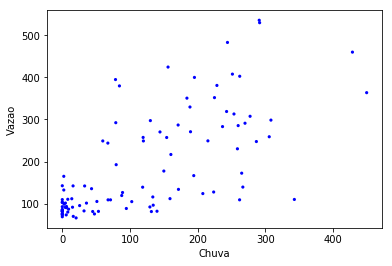

<Figure size 576x432 with 0 Axes>

In [3]:
#Gráfico de dispersão
dados_chuva = dados["1455008"].groupby(pd.Grouper(freq='M')).sum()
dados_vazao = dados["66231000"].groupby(pd.Grouper(freq='M')).mean()
dados_month = pd.DataFrame([dados_chuva, dados_vazao])
thinkplot.Scatter(dados_chuva, dados_vazao, alpha=1.0, s=10)
thinkplot.Show(xlabel='Chuva', ylabel='Vazao', legend=False)
dados_month = dados_month.T

In [4]:
inter, slope = thinkstats2.LeastSquares(dados_chuva.values, dados_vazao.values)
print("Inter: ", round(inter, 4), "\nSlope: ", round(slope, 4))

Inter:  98.5512 
Slope:  0.7476


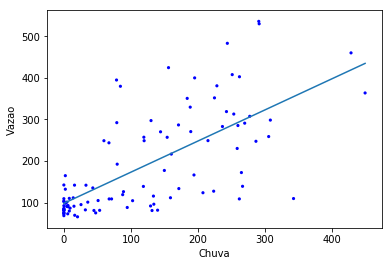

<Figure size 576x432 with 0 Axes>

In [5]:
fit_xs, fit_ys = thinkstats2.FitLine(dados_chuva, inter, slope)
plt.plot(fit_xs, fit_ys)
thinkplot.Scatter(dados_chuva, dados_vazao, alpha=1.0, s=10)
thinkplot.Show(xlabel='Chuva', ylabel='Vazao', legend=False)

## Residual

In [6]:
res = thinkstats2.Residuals(dados_chuva, dados_vazao, inter, slope)
dados_month['Residuos'] = res
bins = np.arange(0, 500, 40)
indices = np.digitize(dados_month["1455008"], bins)
groups = dados_month.groupby(indices)

chuva_means = [group.mean() for _, group in groups][1:-1]

In [7]:
cdfs = [thinkstats2.Cdf(group.Residuos) for _, group in groups][1:-1]

In [8]:
def PlotPercentiles(age_means, cdfs):
    thinkplot.PrePlot(3)
    for percent in [75, 50, 25]:
        weight_percentiles = [cdf.Percentile(percent) for cdf in cdfs]
        label = '%dth' % percent
        thinkplot.Plot(age_means, weight_percentiles, label=label)

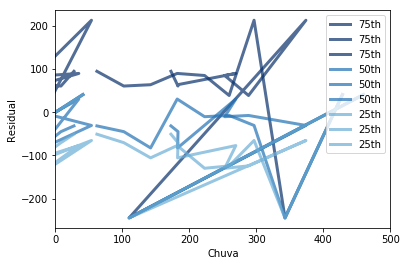

In [9]:
PlotPercentiles(chuva_means, cdfs)

thinkplot.Config(xlabel="Chuva", ylabel='Residual', xlim=[0, 500], legend=True)

In [10]:
print('Média Residual: ', round(dados_month.Residuos.mean(), 4), 
      '\nDesvio Padrão: ', round(dados_month.Residuos.std(), 4))

Média Residual:  -0.0 
Desvio Padrão:  87.8841


- Idealmente, essas linhas deveriam ser planas, indicando que os resíduos são aleatórios;
- E paralelas, indicando que a variância dos resíduos é a mesma para todas as faixas;
- O gráfico não ficou no formato ideal, isso pode ter acontecido devido ao baixo número de dados.

## Estimação

- Os parâmetros inter e slope são estimativas baseadas em uma amostra; como isso são vulneráveis a:
    - Viés de amostragem: causado por amostragem não representativa;
    - Erro de medição: o erro de medição é causado por erros na coleta e registro de dados;
    - Erro de amostragem: resultado da medição de uma amostra em vez de toda a população.

In [11]:
def SamplingDistributions(dados, iters=101):
    
    t = []
    for _ in range(iters):
        sample = thinkstats2.ResampleRows(dados)
        chuva = sample["1455008"]
        vazao = sample["66231000"]
        estimates = thinkstats2.LeastSquares(chuva, vazao)
        t.append(estimates)

    inters, slopes = zip(*t)
    return inters, slopes

In [12]:
inters, slopes = SamplingDistributions(dados_month, iters=1001)

In [13]:
def Summarize(estimates, actual=None):
    mean = thinkstats2.Mean(estimates)
    stderr = thinkstats2.Std(estimates, mu=actual)
    cdf = thinkstats2.Cdf(estimates)
    ci = cdf.ConfidenceInterval(90)
    print('mean: ', mean,  
          '\nSE: ',stderr, 
          '\nCI: ', ci)

In [14]:
Summarize(inters)

mean:  98.46069494026139 
SE:  8.304162496390244 
CI:  (85.40617618538866, 112.88865545911558)


In [15]:
Summarize(slopes)

mean:  0.748415715406996 
SE:  0.08691983498302186 
CI:  (0.6051122682669127, 0.8864839723919666)


In [16]:
def PlotConfidenceIntervals(xs, inters, slopes, percent=90, **options):
    fys_seq = []
    for inter, slope in zip(inters, slopes):
        fxs, fys = thinkstats2.FitLine(xs, inter, slope)
        fys_seq.append(fys)

    p = (100 - percent) / 2
    percents = p, 100 - p
    low, high = thinkstats2.PercentileRows(fys_seq, percents)
    thinkplot.FillBetween(fxs, low, high, **options)

In [17]:
PlotConfidenceIntervals(chuva_means, inters, slopes, percent=90, 
                        color='gray', alpha=0.3, label='90% CI')
PlotConfidenceIntervals(chuva_means, inters, slopes, percent=50,
                        color='gray', alpha=0.5, label='50% CI')

thinkplot.Config(xlabel="Chuva (mm)", ylabel='Vazão (mm)', xlim=[70, 500])

ValueError: could not broadcast input array from shape (9,3) into shape (9)

## Bondade de ajuste

- **Desvio padrão dos resíduos** é a maneira mais simples de medir a bondade do ajuste;
- Outra forma de medir a bondade de ajuste é o **coeficiente de determinação**;
- O coeficiente compara a variância dos resíduos com a variância da variável dependente;


In [18]:
r2 = thinkstats2.CoefDetermination(dados_chuva, res)
r2

0.383540170575809

- Os dados de chuva responde por cerca de 38% dos dados de vazão;
- Existe uma **relação simples** entre o **coeficiente de determinação** e o **coeficiente de correlação de Pearson**:
    - O valor de $R^{2} \approx \rho^{2}$

In [ ]:
print('rho', thinkstats2.Corr(dados_chuva, dados_vazao))
print('R', np.sqrt(r2))   

## Testando um modelo linear

Uma opção é testar se a aparente redução da MSE se deve ao acaso. 
 - Estatística do teste é $R^{2}$ e a hipótese nula é que não há relação entre as variáveis;
 - Um teste unilateral de $R_{2}$ é equivalente a um teste bilateral de $\rho$;
 - Outra abordagem é testar se a inclinação aparente se deve ao acaso.

In [ ]:
class SlopeTest(thinkstats2.HypothesisTest):

    def TestStatistic(self, data):
        chuva, vazao = data
        _, slope = thinkstats2.LeastSquares(chuva, vazao)
        return slope

    def MakeModel(self):
        _, vazao= self.data
        self.ybar = vazao.mean()
        self.res = vazao - self.ybar

    def RunModel(self):
        chuva, _ = self.data
        vazao = self.ybar + np.random.permutation(self.res)
        return chuva, vazao

- A **estatística do teste** é a **inclinação** estimada pelo LeastSquares

In [ ]:
ht = SlopeTest((dados_chuva, dados_vazao))
pvalue = ht.PValue()

In [ ]:
pvalue

- Podemos também utilizar a reamostragem para estimar a distribuição amostral da inclinação.

In [ ]:
reamostragem_cdf = thinkstats2.Cdf(slopes)

In [ ]:
thinkplot.PrePlot(2)
thinkplot.Plot([0, 0], [0, 1], color='0.8')
ht.PlotCdf(label='Hipótese nula')

thinkplot.Cdf(reamostragem_cdf, label='reamostragem')

thinkplot.Config(xlabel='slope',
                 ylabel='CDF',
                 xlim=[-0.5, 1.25],
                 legend=True, loc='upper left')

Podemos calcular o valor-p de duas maneiras:
- Calcular a probabilidade de a inclinação sob a hipótese nula exceder a inclinação observada;
- Calcular a probabilidade de que a inclinação na distribuição amostral caia abaixo de 0. (Se a inclinação estimada fosse negativa, calcularíamos a probabilidade de que a inclinação na distribuição amostral excedesse 0.)

In [19]:
inters, slopes = SamplingDistributions(dados_month, iters=1000)
slope_cdf = thinkstats2.Cdf(slopes)
pvalue = slope_cdf[0]
pvalue

0